# **Mini Project 1**

0. Requirements:
   
   If you do not have the following packages installed, run the command below to install them.

In [3]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install codecarbon
!pip install shap

1. Data Preparation:
   
    Goal: Load and inspect the IMDb dataset containing movie reviews labeled with positive and negative sentiments.(https://ai.stanford.edu/%7Eamaas/data/sentiment/)
    
    Task: Read the dataset, store the reviews and their associated sentiments, and explore the dataset to understand its structure.

In [5]:
import os
import pandas as pd
import numpy as np
import re
import nltk
import shap
import seaborn as sns
import urllib.request
import tarfile
import glob
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from codecarbon import EmissionsTracker

# TASK 1: Data Preparation 
# Load the dataset from the local aclImdb folder
dataset_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_path = "aclImdb_v1.tar.gz"
extracted_folder = "aclImdb"

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(dataset_url, dataset_path)
    print("Download completed.")

if not os.path.exists(extracted_folder):
    print("Extracting dataset...")
    with tarfile.open(dataset_path, "r:gz") as tar:
       tar.extractall(filter="data")  
    print("Extraction completed.")

def load_reviews_from_folder(folder):
    reviews = []
    for file in glob.glob(os.path.join(folder, "*.txt")):
        with open(file, encoding="utf-8") as f:
            reviews.append(f.read())
    return reviews


print("Train Pos files 1:", len(glob.glob("aclImdb/train/pos/*.txt")))
print("Train Neg files 0:", len(glob.glob("aclImdb/train/neg/*.txt")))
print("Test Pos files 1:", len(glob.glob("aclImdb/test/pos/*.txt")))
print("Test Neg files 0:", len(glob.glob("aclImdb/test/neg/*.txt")))

#  Charger les données d'entraînement et de test
train_pos = load_reviews_from_folder("aclImdb/train/pos")
train_neg = load_reviews_from_folder("aclImdb/train/neg")
test_pos = load_reviews_from_folder("aclImdb/test/pos")
test_neg = load_reviews_from_folder("aclImdb/test/neg")

#  Créer un DataFrame pandas pour visualiser les données
df_train = pd.DataFrame({
    "review": train_pos + train_neg,
    "sentiment": [1] * len(train_pos) + [0] * len(train_neg)
})

df_test = pd.DataFrame({
    "review": test_pos + test_neg,
    "sentiment": [1] * len(test_pos) + [0] * len(test_neg)
})

print(f"Total train reviews: {len(df_train)}")
print(f"Total test reviews: {len(df_test)}")

#  Aperçu des données
print("\n----------------------------------------------------------------")
print("Aperçu des données d'entraînement :")
print(df_train.head())
print("\n----------------------------------------------------------------")
print("Aperçu des données de test :")
print(df_test.head())

Train Pos files 1: 12500
Train Neg files 0: 12500
Test Pos files 1: 12500
Test Neg files 0: 12500
Total train reviews: 25000
Total test reviews: 25000

----------------------------------------------------------------
Aperçu des données d'entraînement :
                                              review  sentiment
0  Bromwell High is a cartoon comedy. It ran at t...          1
1  Homelessness (or Houselessness as George Carli...          1
2  Brilliant over-acting by Lesley Ann Warren. Be...          1
3  This is easily the most underrated film inn th...          1
4  This is not the typical Mel Brooks film. It wa...          1

----------------------------------------------------------------
Aperçu des données de test :
                                              review  sentiment
0  I went and saw this movie last night after bei...          1
1  Actor turned director Bill Paxton follows up h...          1
2  As a recreational golfer with some knowledge o...          1
3  I saw thi

2. Text Preprocessing:
   
    Goal: Clean and preprocess the text data to remove noise and prepare it for analysis.
    
    Task: Remove unnecessary characters (e.g., HTML tags, punctuation), convert text to lowercase, and process words by removing stop words and stemming/lemmatizing them.

In [7]:

# Initialiser le stemmer
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Supprimer les balises HTML
    text = re.sub(r'<.*?>', '', text)

    # 2. Supprimer les caractères spéciaux et la ponctuation (ne garder que les lettres et les espaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 3. Convertir en minuscules
    text = text.lower()

    # 4. Supprimer les stop words et appliquer le stemming
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]

    # 5. Reconstruire le texte
    return ' '.join(words)

# Appliquer le prétraitement sur les jeux de données
df_train["clean_review"] = df_train["review"].apply(preprocess_text)
df_test["clean_review"] = df_test["review"].apply(preprocess_text)

# Aperçu des données après prétraitement
print("\n----------------------------------------------------------")
print("Aperçu du text d'entraînement :")
print(df_train[["review", "clean_review"]].head(10))
print("\n----------------------------------------------------------")
print("Aperçu du text de test :")
print(df_test[["review", "clean_review"]].head(10))


----------------------------------------------------------
Aperçu du text d'entraînement :
                                              review  \
0  Bromwell High is a cartoon comedy. It ran at t...   
1  Homelessness (or Houselessness as George Carli...   
2  Brilliant over-acting by Lesley Ann Warren. Be...   
3  This is easily the most underrated film inn th...   
4  This is not the typical Mel Brooks film. It wa...   
5  This isn't the comedic Robin Williams, nor is ...   
6  Yes its an art... to successfully make a slow ...   
7  In this "critically acclaimed psychological th...   
8  THE NIGHT LISTENER (2006) **1/2 Robin Williams...   
9  You know, Robin Williams, God bless him, is co...   

                                        clean_review  
0  bromwel high cartoon comedi ran time program s...  
1  homeless houseless georg carlin state issu yea...  
2  brilliant overact lesley ann warren best drama...  
3  easili underr film inn brook cannon sure flaw ...  
4  typic mel bro

3. Feature Extraction:

    Goal: Transform the cleaned text into numerical features for machine learning.
   
    Task: Use a vectorization technique such as TF-IDF to convert the text into a numerical matrix that captures the importance of each word in the dataset.

In [9]:
# TASK 3: Feature Extraction 

# Importer le vecteur TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialiser le vectoriseur TF-IDF
#on garde seulement les 5 000 mots les plus significatifs, c'est-à-dire ceux ayant les valeurs TF-IDF les plus élevées
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

# Appliquer TF-IDF sur les données d'entraînement et de test
try:
    X_train_tfidf = tfidf_vectorizer.fit_transform(df_train["clean_review"])
    X_test_tfidf = tfidf_vectorizer.transform(df_test["clean_review"])
except Exception as e:
    print(f"Error during TF-IDF vectorization: {e}")

# Récupérer les labels (sentiments)
y_train = df_train["sentiment"]
y_test = df_test["sentiment"]

# Afficher la forme des matrices
print("Taille de X_train_tfidf :", X_train_tfidf.shape)
print("Taille de X_test_tfidf  :", X_test_tfidf.shape)

# Afficher les mots les plus importants
feature_names = tfidf_vectorizer.get_feature_names_out()
print("\nMots les plus importants (top 10) :")
print(feature_names[:10])

Taille de X_train_tfidf : (25000, 5000)
Taille de X_test_tfidf  : (25000, 5000)

Mots les plus importants (top 10) :
['abandon' 'abc' 'abil' 'abl' 'abomin' 'aborigin' 'abort' 'abound'
 'abraham' 'abrupt']


4. Model Training:

    Goal: Train a machine learning model to classify reviews based on their sentiment.
    
    Task: Split the dataset into training and testing sets, train a Logistic Regression model, and evaluate its performance on the test data.

In [11]:
# TASK 8: Track emissions during model training

# Importer les bibliothèques nécessaires
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from codecarbon import EmissionsTracker

# Suivi des émissions carbone
#tracker = EmissionsTracker()
tracker = EmissionsTracker(allow_multiple_runs=True)

try:
    tracker.start()

    # Initialiser et entraîner la régression logistique
    model = LogisticRegression(max_iter=500, solver="liblinear")
    model.fit(X_train_tfidf, y_train)

    # Arrêter le suivi des émissions
    tracker.stop()

    # Prédictions sur l'ensemble de test
    y_pred = model.predict(X_test_tfidf)

    # Évaluation du modèle
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("\nClassification Report :\n", classification_report(y_test, y_pred))
    print("\nConfusion Matrix :\n", confusion_matrix(y_test, y_pred))

    # Afficher les émissions de carbone
    print("\nEmissions de carbone :")
    print(tracker.final_emissions)

except Exception as e:
    print(f"Error during model training or emissions tracking: {e}")
    tracker.stop()

[codecarbon WARNING @ 10:48:52] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:48:52] [setup] RAM Tracking...
[codecarbon INFO @ 10:48:52] [setup] CPU Tracking...
[codecarbon WARNING @ 10:48:52] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 10:48:54] We saw that you have a 12th Gen Intel(R) Core(TM) i3-1215U but we don't know it. Please contact us.
[codecarbon INFO @ 10:48:54] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i3-1215U
[codecarbon INFO @ 10:48:54] [setup] GPU Tracking...
[codecarbon INFO @ 10:48:54] No GPU found.
[codecarbon INFO @ 10:48:54] >>> Tracker's metadata:
[codecarbon INFO @ 10:48:54]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 10:48:54]   Python version: 3.12.7
[codecarbon INFO @ 10:48:54]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 10:48:54]   Available RAM : 7.679 

Accuracy : 0.87024

Classification Report :
               precision    recall  f1-score   support

           0       0.87      0.87      0.87     12500
           1       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000


Confusion Matrix :
 [[10847  1653]
 [ 1591 10909]]

Emissions de carbone :
1.9018102566517762e-08


5. Model Evaluation:

    Goal: Assess the performance of your model using appropriate metrics.
    
    Task: Evaluate precision, recall, and F1-score of the Logistic Regression model. Use these metrics to identify the strengths and weaknesses of your system. Visualize the Confusion Matrix to better understand how well the model classifies positive and negative reviews. Additionally, test the model with a new review, preprocess it, make a prediction, and display the result. Example: test it with a new review such as:
    "The movie had great visuals, but the storyline was dull and predictable." The expected output might be: Negative Sentiment.

 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87     12500
           1       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



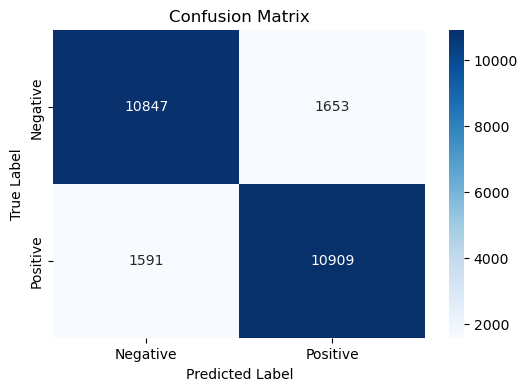

 Review: The movie had great visuals, but the storyline was dull and predictable.
 Predicted Sentiment: Negative Sentiment


In [13]:
# TASK 5: Model Evaluation 
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print(" Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
# Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Test with a new review
new_review = ["The movie had great visuals, but the storyline was dull and predictable."]
new_review_vectorized = tfidf_vectorizer.transform(new_review)
prediction = model.predict(new_review_vectorized)

#review = "The movie had great visuals but the storyline was dull and predictable."
# Résultat
sentiment = "Positive Sentiment" if prediction[0] == 1 else "Negative Sentiment"
print(f" Review: {new_review[0]}")
print(f" Predicted Sentiment: {sentiment}")

6. Hyperparameter Tuning:

    Goal: Optimize your Logistic Regression model by tuning its hyperparameters.
   
    Task: Use an optimization method to find the best parameters for your model and improve its accuracy.

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# TASK 6: Hyperparameter Tuning 

param_grid = [
    {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs'], 'penalty': ['l2']},
    { 'C': [0.01, 0.1, 1, 10, 100],  # Contrôle la régularisation
     'penalty': ['l1', 'l2'],  # Type de régularisation
     'solver': ['liblinear', 'saga'] } # Algorithme d'optimisation
]

# TASK 8: Track emissions during Hyperparameter Tuning
# Initialisation du modèle
logreg = LogisticRegression(max_iter=1000)

# Démarrer le suivi des émissions
#tracker = EmissionsTracker()
tracker = EmissionsTracker(allow_multiple_runs=True)
tracker.start()

try:
    # Grid Search pour trouver les meilleurs paramètres
    grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_tfidf, y_train)

    # Arrêter le suivi des émissions
    tracker.stop()

    # Afficher les meilleurs paramètres
    print("Meilleurs paramètres :", grid_search.best_params_)
    print("Meilleure précision :", grid_search.best_score_)

    # Réentraîner le modèle avec les meilleurs paramètres
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_tfidf)

    # Évaluer la performance
    print("\nNouvelle précision :", accuracy_score(y_test, y_pred))
    print("\nClassification Report après hyperparameter tuning :\n", classification_report(y_test, y_pred))

    # Afficher les émissions de carbone
    print("\nEmissions de carbone :")
    print(tracker.final_emissions)

except Exception as e:
    print(f"Error during hyperparameter tuning or emissions tracking: {e}")
    tracker.stop()

[codecarbon WARNING @ 11:43:58] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 11:43:58] [setup] RAM Tracking...
[codecarbon INFO @ 11:43:58] [setup] CPU Tracking...
[codecarbon WARNING @ 11:43:58] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 11:44:00] We saw that you have a 12th Gen Intel(R) Core(TM) i3-1215U but we don't know it. Please contact us.
[codecarbon INFO @ 11:44:00] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i3-1215U
[codecarbon INFO @ 11:44:00] [setup] GPU Tracking...
[codecarbon INFO @ 11:44:00] No GPU found.
[codecarbon INFO @ 11:44:00] >>> Tracker's metadata:
[codecarbon INFO @ 11:44:00]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 11:44:00]   Python version: 3.12.7
[codecarbon INFO @ 11:44:00]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 11:44:00]   Available RAM : 7.679 

Meilleurs paramètres : {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Meilleure précision : 0.8528

Nouvelle précision : 0.86884

Classification Report après hyperparameter tuning :
               precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.86      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000


Emissions de carbone :
2.074648160382184e-05


7. Learning Curve Analysis:

    Goal: Diagnose your model's performance by plotting learning curves.
   
    Task: Analyze training and validation performance as a function of the training set size to identify underfitting or overfitting issues.


Distribution des classes dans le sous-ensemble :
sentiment
0    11250
1    11250
Name: count, dtype: int64


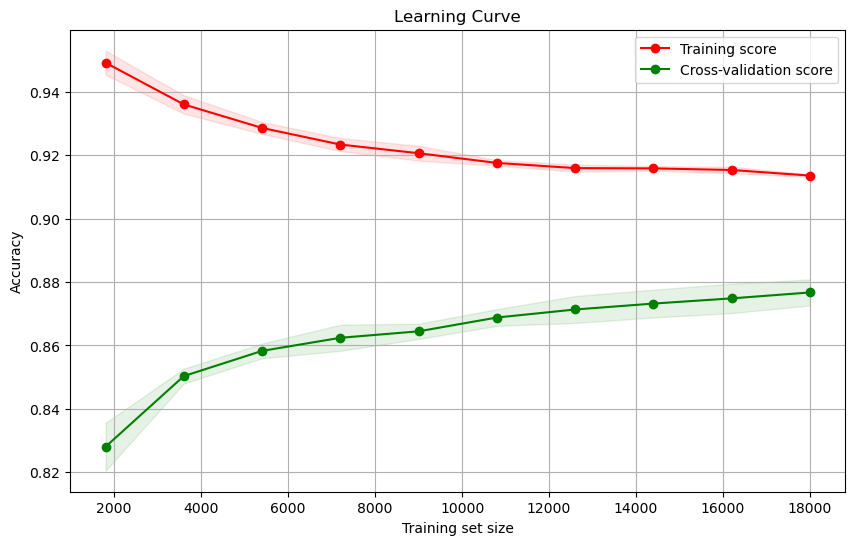

In [58]:
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Définir la taille du sous-ensemble
subset_size = 0.9  # 90% des données

# Utiliser StratifiedShuffleSplit pour diviser les données de manière stratifiée
sss = StratifiedShuffleSplit(n_splits=1, test_size=1 - subset_size, train_size=subset_size, random_state=42)

# Sélectionner le sous-ensemble
for train_index, _ in sss.split(X_train_tfidf, y_train):
    X_train_tfidf_subset = X_train_tfidf[train_index]
    y_train_subset = y_train[train_index]

# Vérifier la distribution des classes dans le sous-ensemble
print("Distribution des classes dans le sous-ensemble :")
print(pd.Series(y_train_subset).value_counts())

# Initialiser le modèle avec les meilleurs paramètres trouvés précédemment
best_model = LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=1000)

# Utiliser StratifiedKFold pour s'assurer que chaque partition contient un nombre représentatif de chaque classe
cv = StratifiedKFold(n_splits=5)

# Calculer les courbes d'apprentissage avec error_score='raise' pour déboguer les échecs
try:
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train_tfidf_subset, y_train_subset, cv=cv, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, error_score='raise'
    )
except ValueError as e:
    print(f"Error during learning curve calculation: {e}")

# Calculer les moyennes et les écarts-types des scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Tracer les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='g')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.show()


8. Carbon Footprint Analysis with CodeCarbon
Goal: Quantify and discuss the carbon footprint of your model using the CodeCarbon methodology.
Task: Install and integrate CodeCarbon into your project. Track and report carbon emissions of your model. You can find needed information here: https://mlco2.github.io/codecarbon/  &  https://codecarbon.io/


In [60]:
from codecarbon import EmissionsTracker
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialiser le modèle avec les meilleurs paramètres trouvés précédemment
best_model = LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=1000)

# Démarrer le suivi des émissions
tracker = EmissionsTracker(allow_multiple_runs=True)
tracker.start()

# Entraîner le modèle
best_model.fit(X_train_tfidf_subset, y_train_subset)

# Arrêter le suivi des émissions
tracker.stop()

# Prédictions sur l'ensemble de test
y_pred = best_model.predict(X_test_tfidf)

# Évaluer la performance
print("\nNouvelle précision :", accuracy_score(y_test, y_pred))
print("\nClassification Report après hyperparameter tuning :\n", classification_report(y_test, y_pred))

# Afficher les émissions de carbone
print("\nEmissions de carbone :")
print(tracker.final_emissions)


[codecarbon WARNING @ 12:02:22] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 12:02:22] [setup] RAM Tracking...
[codecarbon INFO @ 12:02:22] [setup] CPU Tracking...
[codecarbon WARNING @ 12:02:22] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 12:02:24] We saw that you have a 12th Gen Intel(R) Core(TM) i3-1215U but we don't know it. Please contact us.
[codecarbon INFO @ 12:02:24] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i3-1215U
[codecarbon INFO @ 12:02:24] [setup] GPU Tracking...
[codecarbon INFO @ 12:02:24] No GPU found.
[codecarbon INFO @ 12:02:24] >>> Tracker's metadata:
[codecarbon INFO @ 12:02:24]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 12:02:24]   Python version: 3.12.7
[codecarbon INFO @ 12:02:24]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 12:02:24]   Available RAM : 7.679 


Nouvelle précision : 0.8694

Classification Report après hyperparameter tuning :
               precision    recall  f1-score   support

           0       0.87      0.87      0.87     12500
           1       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000


Emissions de carbone :
1.5767014795097618e-08


9. Ethical Considerations and Explainability:

    Goal: Discuss the ethics in using and deploying your AI-based solution by investigating and implementing suitable explainability methods.
    
    Task: Understanding how a machine learning model makes predictions is crucial for ensuring transparency, fairness, and accountability in AI deployment. One of the widely used techniques for model explainability is SHAP (SHapley Additive exPlanations), which helps determine how much each feature (word) contributes to a prediction.
    In this task, you will use SHAP to analyze the impact of individual words on sentiment classification. This will allow you to visualize which words increase or decrease the probability of a positive or negative sentiment prediction. Additionally, discuss key aspects such as potential biases in the model, fairness in outcomes, and accountability in AI decision-making. You can find more information here: https://shap.readthedocs.io/en/latest/generated/shap.Explanation.html

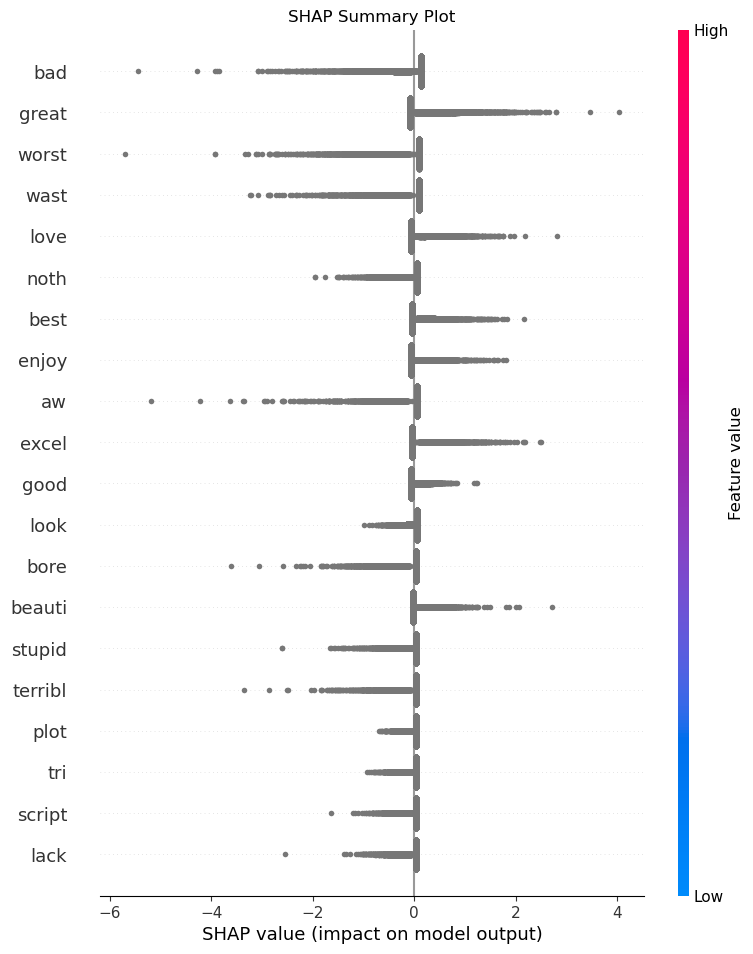

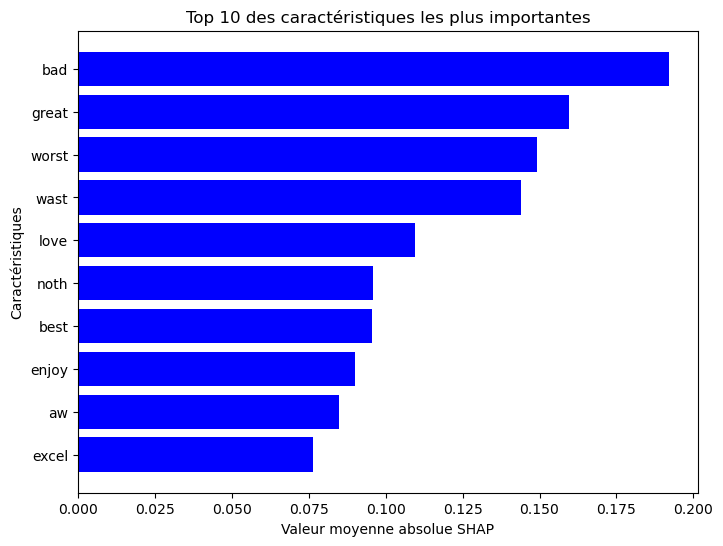

Caractéristiques les plus importantes :
bad: 0.1919123510872314
great: 0.15964594184700176
worst: 0.1493132027173116
wast: 0.14403702491729076
love: 0.1094202954073781
noth: 0.09597852184587209
best: 0.09539396070493607
enjoy: 0.09008298887247966
aw: 0.08493765966675994
excel: 0.07640887899586542


In [63]:
# TASK 9: Ethical Considerations & Explainability

# Show SHAP summary plot with proper feature names
import shap
import matplotlib.pyplot as plt

# Initialiser le modèle avec les meilleurs paramètres trouvés précédemment
best_model = LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=1000)
best_model.fit(X_train_tfidf_subset, y_train_subset)

# Utiliser SHAP pour expliquer le modèle
explainer = shap.Explainer(best_model, X_train_tfidf_subset)
shap_values = explainer(X_test_tfidf)

# Vérifiez que les valeurs SHAP ne sont pas vides
#if shap_values is not None and shap_values.values is not None:
    # Visualiser le résumé SHAP
#    shap.summary_plot(shap_values, feature_names=tfidf_vectorizer.get_feature_names_out(), plot_type="dot")
#    plt.title("SHAP Summary Plot")
#    plt.show()
#else:
#print("Les valeurs SHAP sont vides ou nulles.")

# Vérifiez que les valeurs SHAP ne sont pas vides
if shap_values is not None and shap_values.values is not None:
    # Première figure : SHAP Summary Plot
    plt.figure(figsize=(8, 6))
    shap.summary_plot(shap_values, feature_names=tfidf_vectorizer.get_feature_names_out(), plot_type="dot", show=False)
    plt.title("SHAP Summary Plot")
    plt.show()

    # Deuxième figure : Bar Chart des caractéristiques les plus importantes
    feature_importance = np.mean(np.abs(shap_values.values), axis=0)
    sorted_idx = np.argsort(feature_importance)[::-1]

    top_features = 10  # Nombre de caractéristiques à afficher
    top_importance = feature_importance[sorted_idx[:top_features]]
    top_feature_names = tfidf_vectorizer.get_feature_names_out()[sorted_idx[:top_features]]

    plt.figure(figsize=(8, 6))
    plt.barh(top_feature_names[::-1], top_importance[::-1], color="blue")
    plt.xlabel("Valeur moyenne absolue SHAP")
    plt.ylabel("Caractéristiques")
    plt.title("Top 10 des caractéristiques les plus importantes")
    plt.show()

else:
    print("Les valeurs SHAP sont vides ou nulles.")

# Afficher les caractéristiques les plus importantes
feature_importance = np.mean(np.abs(shap_values.values), axis=0)
sorted_idx = np.argsort(feature_importance)[::-1]
print("Caractéristiques les plus importantes :")
for i in sorted_idx[:10]:
    print(f"{tfidf_vectorizer.get_feature_names_out()[i]}: {feature_importance[i]}")

Cette partie est très pertinente, car elle met en avant des enjeux cruciaux liés à l’utilisation de l’IA, notamment :  

1. **Les biais potentiels du modèle**   
   - Les modèles d’apprentissage automatique peuvent refléter des biais présents dans les données d'entraînement.  
   - Par exemple, si les avis utilisés pour entraîner un modèle de classification de sentiments proviennent majoritairement d’un groupe démographique spécifique, cela peut influencer les résultats et créer des distorsions.  
   - SHAP peut aider à détecter ces biais en montrant quels mots influencent les prédictions et s’il y a des tendances non souhaitées (ex. un biais envers certains termes).  

2. **L’équité des résultats**  
   - Un modèle est-il équitable si certaines classes de données sont systématiquement défavorisées ?  
   - Est-ce que des termes neutres sont associés à des sentiments positifs ou négatifs de manière injustifiée ?  
   - L’analyse SHAP permet d’évaluer si certaines catégories de textes sont traitées différemment et d’identifier des corrections potentielles.  

3. **La responsabilité dans la prise de décision par l’IA**   
   - Comprendre comment un modèle prend ses décisions est essentiel pour qu’il puisse être utilisé en toute confiance.  
   - Un modèle opaque peut être difficile à justifier en cas de mauvaise prédiction ou d’impact négatif.  
   - L’utilisation de SHAP permet d’expliquer les décisions du modèle, ce qui améliore la transparence et permet aux utilisateurs de mieux comprendre et faire confiance aux résultats.  

10. Deployment Considerations for Embedded Systems:

    Goal: Optimize and convert the trained logistic regression model for deployment on embedded systems like Arduino
    
    Task: To deploy the trained logistic regression model on a resource-constrained embedded system like an Arduino, we must optimize and convert the model into a format suitable for execution in an environment with limited memory and processing power. Since embedded systems do not support direct execution of machine learning models trained in Python, we extract the model’s learned parameters—namely, the weights and bias—after training. These parameters are then quantized to fixed-point integers to eliminate the need for floating-point calculations, which are inefficient on microcontrollers.
    Once quantization is applied, we generate a C++ .h header file containing the model’s coefficients and bias, formatted in a way that allows direct use within an Arduino sketch. The final model is optimized to perform inference using integer arithmetic, making it both lightweight and efficient for deployment on microcontrollers. You can find more information here: https://medium.com/@thommaskevin/tinyml-binomial-logistic-regression-0fdbf00e6765

In [66]:
# TASK 10: Deployment Considerations (Model Quantization & Export for Arduino)
# Extract weights and bias from the trained logistic regression model
# Apply quantization (convert to fixed-point representation)
# Generate C++ header file for Arduino
# Save the header file

import numpy as np

# Vérifier que best_model existe (évite les erreurs si le modèle n'est pas entraîné)
try:
    weights = best_model.coef_[0]  # Poids du modèle
    bias = best_model.intercept_[0]  # Biais
except NameError:
    raise ValueError("Erreur : best_model n'est pas défini ou non entraîné.")

# Définir un facteur d'échelle pour la quantification (1000 = 3 décimales de précision)
scale_factor = 1000  

# Convertir les poids et le biais en entiers (int16_t pour Arduino)
weights_quantized = (weights * scale_factor).astype(np.int16)
bias_quantized = int(bias * scale_factor)

# Générer le fichier header C++ pour Arduino
header_file = """#ifndef LOGISTIC_MODEL_H
#define LOGISTIC_MODEL_H

#include <stdint.h>

#define SCALE_FACTOR 1000  // Facteur d'échelle pour convertir en décimal

constexpr int16_t weights[] = {""" + ", ".join(map(str, weights_quantized)) + """};
constexpr int16_t bias = """ + str(bias_quantized) + """;

#endif // LOGISTIC_MODEL_H
"""

# Sauvegarde du fichier
with open("logistic_model.h", "w") as f:
    f.write(header_file)

print("Fichier logistic_model.h généré avec succès !")



Fichier logistic_model.h généré avec succès !
